In [1]:
import numpy as np
from cluster_data import ClusterData, cluster_data_to_array, normalize_data, estimate_runtime
from kmeans import k_means
from my_kmedoids import pam_clustering
from fuzzy_c_means import fuzzy_c_means
import my_kmedoids

def main():
    #Example data: list of ClusterData (3 dimensions: inc, raan, ecc)
    data_list = [
        ClusterData(inc=10.0, raan=20.0, ecc=0.1),
        ClusterData(inc=12.0, raan=22.0, ecc=0.15),
        ClusterData(inc=11.0, raan=21.0, ecc=0.12),
        ClusterData(inc=50.0, raan=60.0, ecc=0.3),
        ClusterData(inc=52.0, raan=62.0, ecc=0.35),
        ClusterData(inc=51.0, raan=61.0, ecc=0.32),
    ]
    
    # Convert the list of named tuples to a numpy array.
    data_array = cluster_data_to_array(data_list)
    
    # Normalize the data.
    normalized_data, data_min, data_max = normalize_data(data_array) 
    k = 2  # Number of clusters
    
    # --- K-means Clustering ---
    print("\nK-means result:")
    result_kmeans, time_kmeans = estimate_runtime(k_means, normalized_data, k, init='random')
    print("Labels:", result_kmeans.labels)
    print("Cluster centers:\n", result_kmeans.cluster_centers)
                                                      
    # --- Fuzzy C-means Clustering ---
    print("\nFuzzy C-means result:")
    result_fcm, time_fcm = estimate_runtime(fuzzy_c_means, normalized_data, k, m=2)
    print("Labels:", result_fcm.labels)
    print("Cluster centers:\n", result_fcm.cluster_centers)                                          

    # --- K-medoids (PAM) Clustering ---
    print("\nK-medoids (PAM) result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, build_function=None, swap_function=None)
    print("Labels:", result_kmedoids.labels)
    print("here")
    print("Cluster centers:\n", result_kmedoids.cluster_centers)

    # --- K-medoids (PAM) Clustering --- FastPAM1
    print("\nK-medoids fastPAM 1 result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, None, my_kmedoids.fastpam1_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers) 
    
    # --- K-medoids (PAM) Clustering --- FastPAM2 and LAB Build
    print("\nK-medoids fastPAM2 + LAB-build result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, my_kmedoids.fastpam_lab_build, my_kmedoids.fastpam2_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers)

if __name__ == "__main__":
    main()


K-means result:
Runtime for k_means (build: default build, swap: default swap): 0.003299 seconds
Labels: [1 1 1 0 0 0]
Cluster centers:
 [[0.97619048 0.97619048 0.89333333]
 [0.02380952 0.02380952 0.09333333]]

Fuzzy C-means result:
Runtime for fuzzy_c_means (build: default build, swap: default swap): 0.000000 seconds
Labels: [0 0 0 1 1 1]
Cluster centers:
 [[0.02379026 0.02379026 0.09316858]
 [0.97617344 0.97617344 0.89327082]]

K-medoids (PAM) result:
Runtime for pam_clustering (build: pam_build, swap: pam_swap): 0.006316 seconds
Labels: [1 1 1 0 0 0]
here
Cluster centers:
 [[0.97619048 0.97619048 0.88      ]
 [0.02380952 0.02380952 0.08      ]]

K-medoids fastPAM 1 result:
Runtime for pam_clustering (build: pam_build, swap: pam_swap): 0.002008 seconds
Labels: [1 1 1 0 0 0]
Cluster centers:
 [[0.97619048 0.97619048 0.88      ]
 [0.02380952 0.02380952 0.08      ]]

K-medoids fastPAM2 + LAB-build result:
Runtime for pam_clustering (build: pam_build, swap: pam_swap): 0.004617 seconds
L


K-means result:
Runtime for k_means (build: default build, swap: default swap): 0.017788 seconds
Labels: [2 2 2 ... 0 0 0]
Cluster centers:
 [[0.6625814  0.5561561  0.03107262]
 [0.3429191  0.84233978 0.87892135]
 [0.30292188 0.32113107 0.87754567]
 [0.08974463 0.678743   0.03299587]]
Runtime: 0.017788 seconds


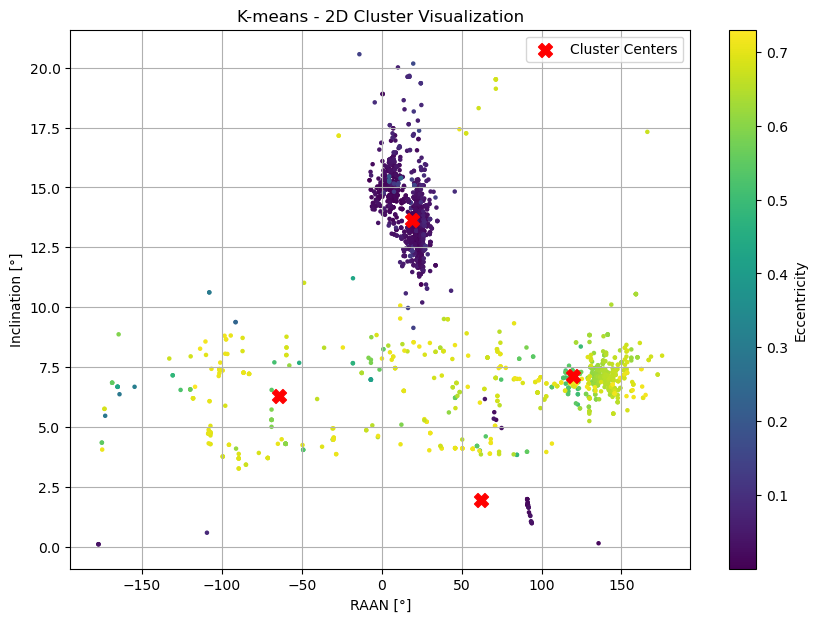


Fuzzy C-means result:
Runtime for fuzzy_c_means (build: default build, swap: default swap): 11.902435 seconds
Labels: [3 3 3 ... 1 1 1]
Cluster centers:
 [[0.32332295 0.63314673 0.89913006]
 [0.65872834 0.55728204 0.02963704]
 [0.34231596 0.88575299 0.87008593]
 [0.28056062 0.25561824 0.8863322 ]]
Runtime: 11.902435 seconds


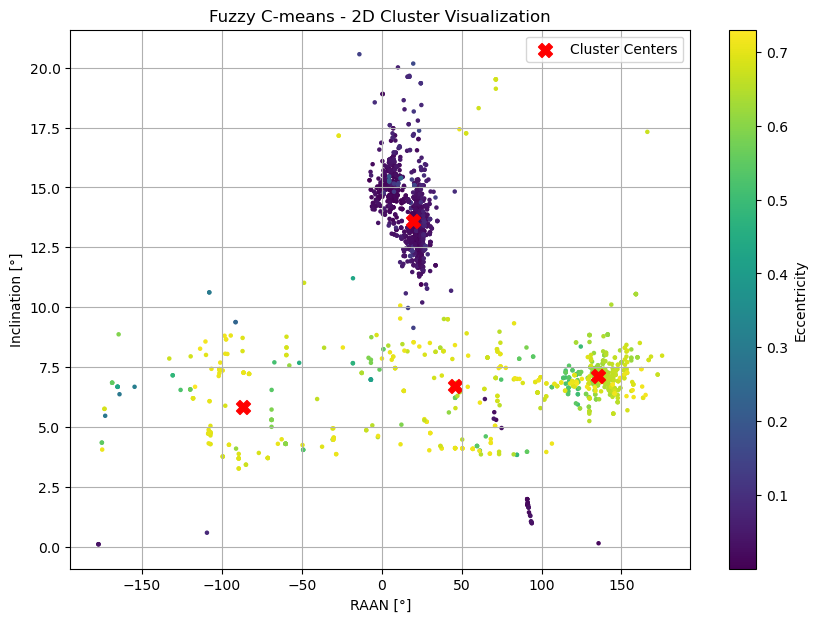


K-medoids fastPAM1 result:


In [ ]:
import numpy as np
import cluster_data
import my_kmedoids
from cluster_plotter import ClusterPlotter
from kmeans import k_means
from fuzzy_c_means import fuzzy_c_means
from my_kmedoids import pam_clustering
#from dbscan import dbscan_clustering

# Load and preprocess data
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 4  # Number of clusters

# Helper function for clustering and plotting
def run_clustering(algorithm, name, data, data_min, data_max, *args, **kwargs):
    """Runs a clustering algorithm, prints results, and visualizes clusters.

    Args:
        algorithm (Callable): Clustering function.
        name (str): Name of the algorithm.
        data (np.array): Normalized dataset.
        data_min (np.array): Minimum values before normalization.
        data_max (np.array): Maximum values before normalization.
        *args: Positional arguments for the clustering function.
        **kwargs: Keyword arguments for the clustering function.

    Returns:
        ClusteringResult: Named tuple with clustering results.
        float: Execution time.
    """
    print(f"\n{name} result:")
    result, runtime = cluster_data.estimate_runtime(algorithm, data, *args, **kwargs)
    print("Labels:", result.labels)
    print("Cluster centers:\n", result.cluster_centers)
    print(f"Runtime: {runtime:.6f} seconds")

    # Unnormalize cluster centers
    unnormalized_data, cluster_centers = cluster_data.unnormalize(result.data, result.cluster_centers, data_min, data_max)

    plotter = ClusterPlotter(unnormalized_data, result.labels, cluster_centers)
    plotter.clusters_2d_plot(f"{name} - 2D Cluster Visualization")
    return result, runtime

# Run clustering algorithms
result_kmeans, time_kmeans = run_clustering(k_means, "K-means", normalized_data, data_min, data_max, k, init='kmeans++')
result_fcm, time_fcm = run_clustering(fuzzy_c_means, "Fuzzy C-means", normalized_data, data_min, data_max, k, m=2)
result_fastpam1, time_fastpam1 = run_clustering(pam_clustering, "K-medoids fastPAM1", normalized_data, data_min, data_max, k, None, my_kmedoids.fastpam1_swap)
result_kmedoids, time_kmedoids = run_clustering(pam_clustering, "K-medoids (PAM)", normalized_data, data_min, data_max, k, build_function=None, swap_function=None)
result_fastpam2, time_fastpam2 = run_clustering(pam_clustering, "K-medoids fastPAM2 + LAB-build", normalized_data, data_min, data_max, k, my_kmedoids.fastpam_lab_build, my_kmedoids.fastpam2_swap)
#result_dbscan, time_dbscan = cluster_data.estimate_runtime(dbscan_clustering, normalized_data, eps=0.5, min_samples=5)

print("\n--- Runtime Summary ---")
print(f"K-means runtime: {time_kmeans:.6f} seconds")
print(f"Fuzzy C-means runtime: {time_fcm:.6f} seconds")
print(f"K-medoids (PAM) runtime: {time_kmedoids:.6f} seconds")
print(f"K-medoids fastPAM1 runtime: {time_fastpam1:.6f} seconds")
print(f"K-medoids fastPAM2 + LAB-build runtime: {time_fastpam2:.6f} seconds")
#print(f"DBSCAN runtime: {time_dbscan:.6f} seconds")

print("\nDBSCAN Clustering Result:")
#print("Labels:", result_dbscan)

# Unnormalize DBSCAN results
unnormalized_data = cluster_data.unnormalize(normalized_data, None, data_min, data_max)[0]

#plotter = ClusterPlotter(unnormalized_data, result_dbscan, None)
#plotter.clusters_3d_plot("DBSCAN 3D Cluster Visualization")
#plotter.clusters_2d_plot("DBSCAN 2D Cluster Visualization")
